# S10 T01: Aprendizaje Supervisado - Clasificaciòn
___
**Descripción**
Vamos a practicar ya familiarizarnos con algoritmos de clasificación .
___
**Objetivos**
- Árboles de clasificación
- KNN - k-Nearest Neighbors
- Regresión Logística
- Support Vector Machine
- XGboost

In [1]:
#load libreries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from math import sqrt
import category_encoders as ce
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 
from sklearn import metrics 
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from numpy import where
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

Definicion de funciones:

In [17]:
# Metrics
def metrics_models(y_test, y_pred, model_name):
    
    # Confusion Matrix
    confusion_matrix_single = metrics.confusion_matrix(y_test, y_pred)

    # DataFrame
    confusion_matrix_df = pd.DataFrame(confusion_matrix_single)

    # Plot matrix in heatmap
    fig, ax = plt.subplots(figsize = (10,5))
    sns.heatmap(pd.DataFrame(confusion_matrix_df), annot=True, fmt='d' ,annot_kws={'size': 12}, cmap = 'YlGnBu') 
    plt.ylabel('Actual', fontsize = 12); 
    plt.xlabel('Predicted', fontsize =12); 
    plt.suptitle(t= 'CONFUSION MATRIX',fontsize =16, fontweight = 'bold'); 
    plt.title(model_name, loc= 'left',fontsize = 14);plt.show()
    
    # Metrics
    Accuracy = round(metrics.accuracy_score(y_test, y_pred),2)
    Precision = round(metrics.precision_score(y_test, y_pred),2)
    Recall = round(metrics.recall_score(y_test, y_pred),2)
    F1 = round(metrics.f1_score(y_test, y_pred),2)
    

    confusion_matrix_metrics = pd.DataFrame([{'Accuracy: ': Accuracy, 'Precision: ': Precision,
    'Recall: ': Recall , 'F1: ': F1 }], index=[model_name])

    print(confusion_matrix_metrics)
    return confusion_matrix_metrics

Primeros pasos:
- 1. Cargar base de datos (se carga la base de datos previamente procesada)

In [2]:
#import te clean dataset 
data = pd.read_csv('df_clean_dbdelay.csv')

- 2. Overview de la base de datos


In [3]:
data.shape

(1928371, 17)

In [4]:
data.head()

,Unnamed: 0,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,Date
0,0,4,2003,1955,2211,2225,WN,335,128,150,116,-14,8,IAD,TPA,810,2008-01-03
1,1,4,754,735,1002,1000,WN,3231,128,145,113,2,19,IAD,TPA,810,2008-01-03
2,2,4,628,620,804,750,WN,448,96,90,76,14,8,IND,BWI,515,2008-01-03
3,3,4,1829,1755,1959,1925,WN,3920,90,90,77,34,34,IND,BWI,515,2008-01-03
4,4,4,1940,1915,2121,2110,WN,378,101,115,87,11,25,IND,JAX,688,2008-01-03


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1928371 entries, 0 to 1928370
Data columns (total 17 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   Unnamed: 0         int64 
 1   DayOfWeek          int64 
 2   DepTime            int64 
 3   CRSDepTime         int64 
 4   ArrTime            int64 
 5   CRSArrTime         int64 
 6   UniqueCarrier      object
 7   FlightNum          int64 
 8   ActualElapsedTime  int64 
 9   CRSElapsedTime     int64 
 10  AirTime            int64 
 11  ArrDelay           int64 
 12  DepDelay           int64 
 13  Origin             object
 14  Dest               object
 15  Distance           int64 
 16  Date               object
dtypes: int64(13), object(4)
memory usage: 250.1+ MB


In [6]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1928371.0,967883.210651,558868.992129,0.0,483955.5,967654.0,1451881.5,1936757.0
DayOfWeek,1928371.0,3.984999,1.996050,1.0,2.0,4.0,6.0,7.0
DepTime,1928371.0,1518.647818,450.435200,1.0,1203.0,1545.0,1900.0,2400.0
CRSDepTime,1928371.0,1467.717509,424.728051,0.0,1135.0,1510.0,1815.0,2359.0
ArrTime,1928371.0,1610.242251,548.000926,1.0,1316.0,1715.0,2030.0,2400.0
CRSArrTime,1928371.0,1634.196234,464.628444,0.0,1325.0,1705.0,2014.0,2359.0
FlightNum,1928371.0,2184.296091,1944.449506,1.0,611.0,1543.0,3423.0,9741.0
ActualElapsedTime,1928371.0,133.305863,72.060069,14.0,80.0,116.0,165.0,1114.0
CRSElapsedTime,1928371.0,134.197674,71.233388,-21.0,82.0,116.0,165.0,660.0
AirTime,1928371.0,108.277147,68.642610,0.0,58.0,90.0,137.0,1091.0


- 3. Limpieza de datos

In [7]:
round(data[:].isnull().sum() * 100 / data.shape[0], 2)

Unnamed: 0           0.0
DayOfWeek            0.0
DepTime              0.0
CRSDepTime           0.0
ArrTime              0.0
CRSArrTime           0.0
UniqueCarrier        0.0
FlightNum            0.0
ActualElapsedTime    0.0
CRSElapsedTime       0.0
AirTime              0.0
ArrDelay             0.0
DepDelay             0.0
Origin               0.0
Dest                 0.0
Distance             0.0
Date                 0.0
dtype: float64

In [3]:
#remove unimportant columns
data = data.drop(['Unnamed: 0'], axis = 1)

Modificacion del dtype de las variables:

In [4]:
#data type object to categoric variables
data[['UniqueCarrier','Origin','Dest']] = data[['UniqueCarrier','Origin','Dest']].astype('category')

In [5]:
data['Date'] = pd.to_datetime(data['Date'])

In [6]:
#data float to int
data[["ActualElapsedTime","CRSElapsedTime","AirTime",'ArrDelay','DepDelay','CRSDepTime','DepTime','CRSArrTime','ArrTime']] = data[["ActualElapsedTime","CRSElapsedTime","AirTime",'ArrDelay','DepDelay','CRSDepTime','DepTime','CRSArrTime','ArrTime']].astype('int64')

In [7]:
data.head()

,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,Date
0,4,2003,1955,2211,2225,WN,335,128,150,116,-14,8,IAD,TPA,810,2008-01-03
1,4,754,735,1002,1000,WN,3231,128,145,113,2,19,IAD,TPA,810,2008-01-03
2,4,628,620,804,750,WN,448,96,90,76,14,8,IND,BWI,515,2008-01-03
3,4,1829,1755,1959,1925,WN,3920,90,90,77,34,34,IND,BWI,515,2008-01-03
4,4,1940,1915,2121,2110,WN,378,101,115,87,11,25,IND,JAX,688,2008-01-03


### DataExploration
Antes de iniciar con los modelos de regresion, se genera un heatmap para observar la correlacion entre la variable dependiente 'ArrDelay' y las variables independientes.

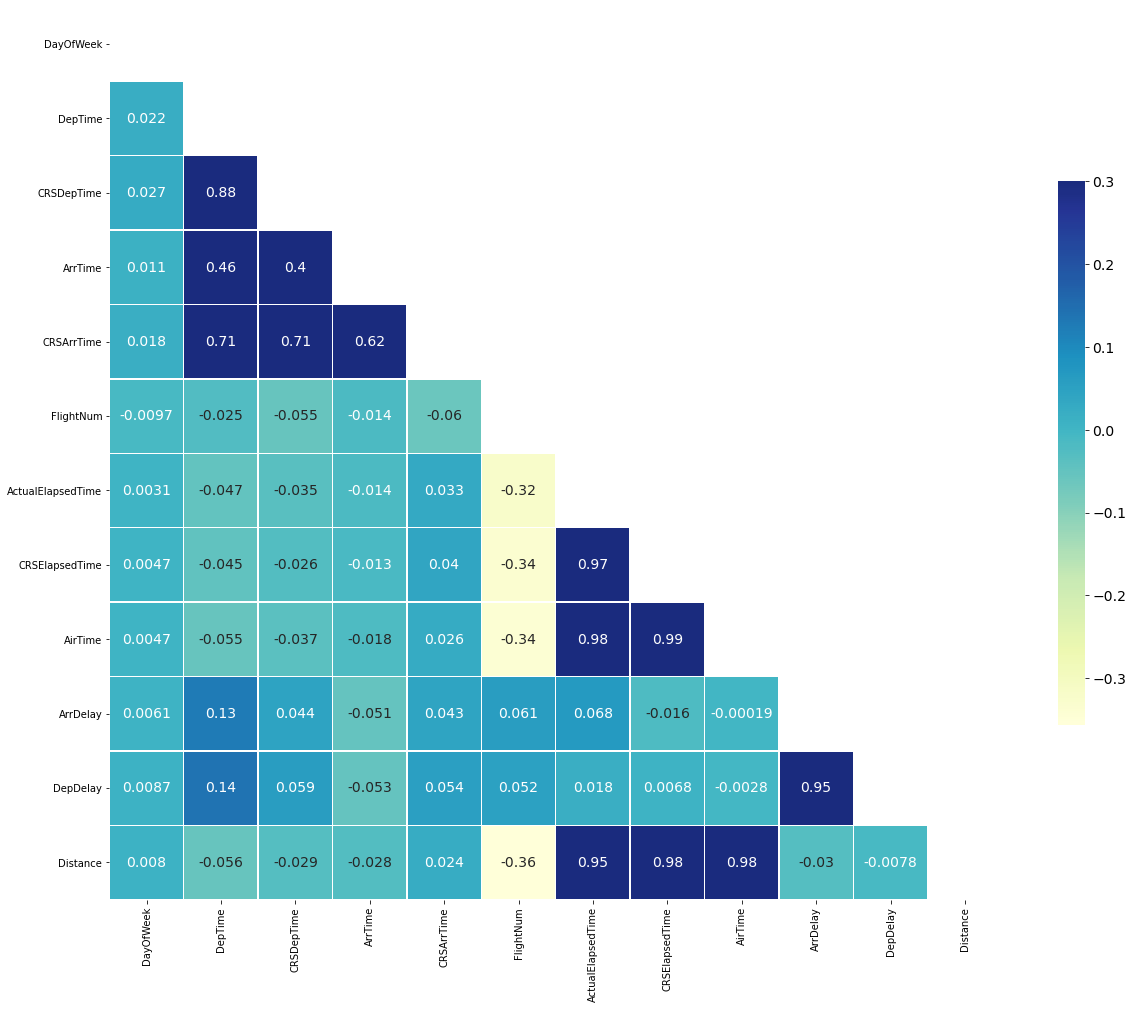

In [8]:
f, ax = plt.subplots(figsize=(20, 20))
#mask for removing the upper triangle
mask = np.triu(np.ones_like(data.corr(), dtype=bool))

plt.rcParams['font.size'] = '14'
sns.heatmap(data.corr(), annot=True, mask=mask, cmap="YlGnBu",vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

## Nivel 1

### - Ejercicio 1
Crea al menos tres modelos de clasificación distintos para intentar predecir lo mejor posible el retraso de los vuelos (ArrDelay) de DelayedFlights.csv. Considera si el vuelo ha llegado tarde o no (ArrDelay > 0).
<br>

* Variable dependiente: ***Arrival delay***


Al tener casi dos millones de datos, se hace un muestreo aleatorio simple para poder optimizar los tiempos de calculo del notebook.
<br>

El sampling por calculo nos dice que una muestra valida puede ser de 400 datos, pero para abarcar un expectro mayor de datos, se ha decidido usar una muestra de mil datos

In [8]:
#Simple Random Sampling
data_sampling = data.sample(1000)
data_sampling.head()

,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,Date
991918,6,1856,1610,1935,1701,EV,4919,39,51,29,154,166,CHA,ATL,106,2008-06-14
276595,5,1832,1815,1937,1920,WN,165,65,65,45,17,17,LAX,LAS,236,2008-02-01
1348643,5,1316,1234,1549,1519,EV,4491,153,165,135,30,42,MHT,ATL,952,2008-08-01
1676148,5,2322,2125,32,2254,DL,981,70,89,55,98,117,ATL,MCO,403,2008-11-28
401100,2,1429,1405,1521,1505,WN,315,52,60,35,16,24,FLL,MCO,178,2008-03-25


### Feature engineering: Normalization of categorical data
Para trabajar los modelos de machine learning es necesario que pueda interpretar los datos de manera correcta, por lo que se van a normalizar las variables categoricas. En este dataset las variables categoricas de interes son 'UniqueCarrier', 'Dest' y 'Origin', pero debido a que la lista de observaciones diferentes es muy amplia podriamos terminar con un dataset de mas de 600 features, por lo que se va a utilizar *target encoder* para no aumentar el tamaño del dataset y faciliar su procesamiento.

*https://medium.com/analytics-vidhya/target-encoding-vs-one-hot-encoding-with-simple-examples-276a7e7b3e64*


In [9]:
encoder = TargetEncoder()
data_sampling[['Origin','Dest','UniqueCarrier']]=encoder.fit_transform(data_sampling[['Origin','Dest','UniqueCarrier']],data_sampling['ArrDelay'])

data_sampling.head()

C:\Users\Usuario\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,Date
991918,6,1856,1610,1935,1701,33.230769,4919,39,51,29,154,166,137.593017,47.666667,106,2008-06-14
276595,5,1832,1815,1937,1920,30.083770,165,65,65,45,17,17,41.585366,25.258065,236,2008-02-01
1348643,5,1316,1234,1549,1519,33.230769,4491,153,165,135,30,42,26.523409,47.666667,952,2008-08-01
1676148,5,2322,2125,32,2254,36.406780,981,70,89,55,98,117,38.719298,44.000000,403,2008-11-28
401100,2,1429,1405,1521,1505,30.083770,315,52,60,35,16,24,11.648413,44.000000,178,2008-03-25


### Creacion de nueva variable: ArrDelay > 0
Modificamos la variable ArrDelay para cumplir con la instruccion de: si el vuelo ha llegado tarde o no (ArrDelay > 0).

In [10]:
data_sampling['ArrDelay'] = [1 if x > 1 else 0 for x in data_sampling['ArrDelay']]
print(data_sampling['ArrDelay'].value_counts(normalize=True).round(2))
print(data_sampling['ArrDelay'].value_counts())

1    0.88
0    0.12
Name: ArrDelay, dtype: float64
1    881
0    119
Name: ArrDelay, dtype: int64


### Feature selection
Dividimos las variables en dependiente (target) e independientes (features)

In [11]:
#Split data in features and target variable
#data/predictors   
X = data_sampling.drop(['ArrDelay','Date'], axis=1)
#target variable
y = data_sampling.ArrDelay

### Train test dataset
Dividimos el dataset en training y test para probar los modelos, con una relacion de 80-20% y Se divide el dataset en los predictores (X) y la variable target (Y)

In [12]:
#split test-train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
# shape of the train and test
print(X_train.shape, '\n', X_test.shape, '\n', y_train.shape, '\n', y_test.shape)

(800, 14) 
 (200, 14) 
 (800,) 
 (200,)


### Nota inicial:

**Se han iniciado los modelos sin pasar parametros para probar la version default que tienen, y asi observar como varian los resultados obtenidos al incluirle parametros como se solicita en el ejercicio 3**

### Primer modelo: Decision Tree
Los arboles de decision son modelos con estructura de arbol similares a diagramas de flujo, donde un nodo interno representa una funcion (o atributo), la rama representa una regla de decision y cada nodo hoja representa un resultado. El nodo superior de un árbol de decisión se conoce como nodo raíz.

* Pros:
>- faciles de interpretar
>- captura patrones no lineales
>- requiere menos preprocesamiento de datos
>- no tiene suposiciones sobre la distribucion de los datos

* Contras:
>- sensible a datos ruidosos
>- estan sesgados con un conjunto de datos de desequilibrio



In [14]:
# instantiate Decision Tree classifer 
dt_class = DecisionTreeClassifier()

# Train Decision Tree Classifer
dt_class = dt_class.fit(X_train,y_train)

#Predict the response for test dataset
y_pred_dt = dt_class.predict(X_test)


### Segundo modelo: KNN k- nearest neighbors

Es un algoritmo de clasificacion que no requiere entrenamiento para realizar predicciones y es un algoritmo de aprendizaje no paramétrico, lo que significa que no asume nada sobre los datos subyacentes.

<br>

*https://stackabuse.com/k-nearest-neighbors-algorithm-in-python-and-scikit-learn/*

In [15]:
#instantiate Kn Classifier
kn_class = KNeighborsClassifier(n_neighbors=5)

#Train Kn Classifier
kn_class.fit(X_train, y_train)

#Predict with test data
y_pred_kn = kn_class.predict(X_test)


### Tercer modelo: XGBoost
Se decididio utilizar el XGBoost debido a que es uno de los algoritmos mas populares en ML, combina un set de weak learners y genera prediccion mejoradas. Entre las principales pros se encuentra que:
- Es mas rapido que otros clasificadores
- Entrena bien con dataset grandes
- Tiene mejor performance que otros algoritmos ML

<br>

*https://www.datacamp.com/community/tutorials/xgboost-in-python*

In [16]:
#instantiate XGBoost classifier
xg_class = xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)

#fit the classification
xg_class.fit(X_train,y_train)

#Predict on test
y_preds_xgb = xg_class.predict(X_test)


### - Ejercicio 2
Compara los modelos de clasificación utilizando la precisión (accuracy), una matriz de confianza y otras métricas más avanzadas.

- Accuracy: 
Muestra cuantas predicciones son correctas.

- Confusion matrix:
No es una métrica para evaluar un modelo, pero proporciona información sobre las predicciones. Se utiliza para calcular la precisión y la recuperación. 

>Los términos clave de la matriz de confusión son los siguientes:
>* Verdadero positivo (TP) : Predecir la clase positiva como positiva (ok)
>* Falso positivo (FP) : Predecir la clase negativa como positiva (no está bien)
>* Falso negativo (FN) : predicción de clase positiva como negativa (no está bien)
>* Verdadero negativo (TN) : Predicción de clase negativa como negativa (ok)
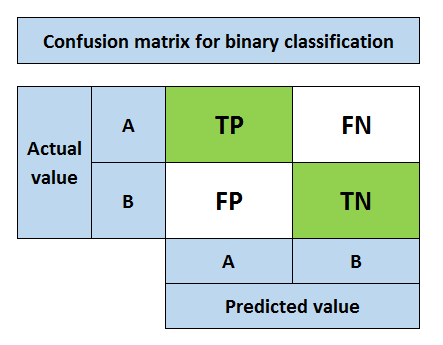

- Precisión: 
Mide qué tan bueno es nuestro modelo cuando la predicción es positiva

- Recall:
Mide qué tan bueno es nuestro modelo para predecir correctamente las clases positivas

- Puntuación F1:
Promedio ponderado de precisión y recuperación

- Sensitivity and Specificity:
Sensibilidad es la tasa de verdaderos positivos (TPR), mide la proporción de clase positiva que se predice correctamente como positiva. Especificidad mide la proporción de clase negativa que se predice correctamente como negativa.

- Curva ROC y AUC:
La curva ROC resume el rendimiento del modelo en diferentes valores de umbral mediante la combinación de matrices de confusión en todos los valores de umbral. AUC agrega el rendimiento del modelo en todos los valores de umbral. 

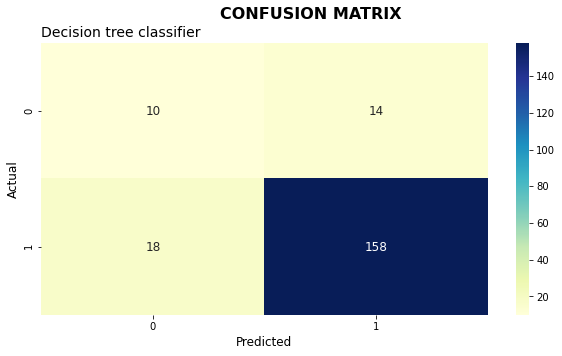

                          Accuracy:   Precision:   Recall:   F1: 
Decision tree classifier        0.84         0.92       0.9  0.91


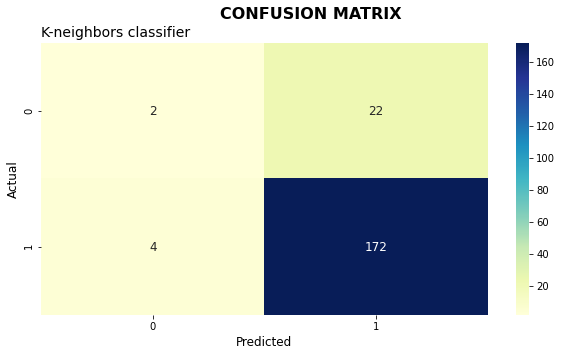

                        Accuracy:   Precision:   Recall:   F1: 
K-neighbors classifier        0.87         0.89      0.98  0.93


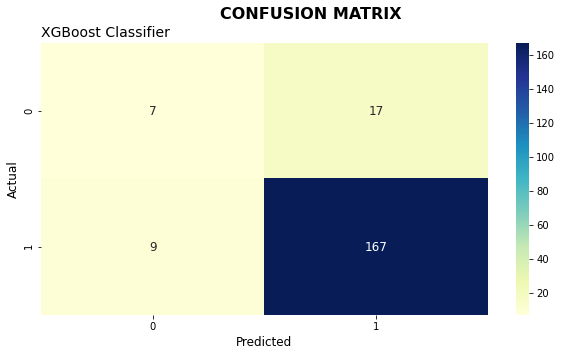

                    Accuracy:   Precision:   Recall:   F1: 
XGBoost Classifier        0.87         0.91      0.95  0.93


In [18]:
comparing_classification_models=pd.DataFrame()
comparing_classification_models = comparing_classification_models.append(metrics_models(y_test, y_pred_dt, 'Decision tree classifier'))
comparing_classification_models = comparing_classification_models.append(metrics_models(y_test, y_pred_kn, 'K-neighbors classifier'))
comparing_classification_models = comparing_classification_models.append(metrics_models(y_test, y_preds_xgb, 'XGBoost Classifier'))


In [19]:
comparing_classification_models

,Accuracy:,Precision:,Recall:,F1:
Decision tree classifier,0.84,0.92,0.90,0.91
K-neighbors classifier,0.87,0.89,0.98,0.93
XGBoost Classifier,0.87,0.91,0.95,0.93


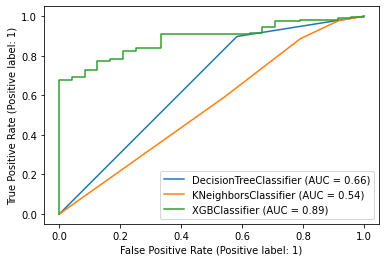

In [20]:
disp = plot_roc_curve(dt_class,X_test,y_test)
plot_roc_curve(kn_class,X_test,y_test, ax=disp.ax_);
plot_roc_curve(xg_class,X_test,y_test, ax=disp.ax_);

### Comparacion de modelos:
Se puede observar que el accuracy de los modelos XGBoost y KNN es el mismo (87%), mientras que el que tiene menor es Decission tree (84%). Se observa que el modelo con mayor precision es Decision tree classifier, aunque los modelos XGBoost y KNN tienen una precision alta tambien (91 y 89, respectivamente). Se observa que el que tiene mayor recall es el KNN(98%), mientras que XGBoost tiene 95% y Decision tree tiene 90%. Se observa que el F1 se mantiene similar en los tres modelos.
<br>

Por ultimo, analizando la curva ROC nos muestra el AUC reflejando el rendimiento del modelo en todos los valores del umbral, en el se observa que los valores de los modelos son distintos, donde el que tiene mejor rendimiento es XGBoost con 0.89, mientras el que tiene menor rendimiento es KNN con 0.54). Observando la curva ROC se observa que el modelo XGBoost tiene mejor rendimiento al clasificar.
<br>

*https://www.youtube.com/watch?v=OAl6eAyP-yo&ab_channel=DataSchool*

### - Ejercicio 3
Entrena utilizando los diferentes parámetros que admiten.

### Primer modelo: Decision Tree
El modelo tiene varios parametros: 
   >class sklearn.tree.DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, class_weight=None, ccp_alpha=0.0)[source]
   
De los cuales modificaremos: 
   > **criterion:{“gini”, “entropy”}, default=”gini”**
The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

   > **splitter:{“best”, “random”}, default=”best”**
The strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

   > **max_depth:int, default=None**
The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

In [21]:
# Create Decision Tree classifer object
dt_class2 = DecisionTreeClassifier(criterion="entropy", splitter='random', max_depth=3)

# Train Decision Tree Classifer
dt_class2 = dt_class2.fit(X_train,y_train)

#Predict the response for test dataset
y_pred2 = dt_class2.predict(X_test)


### Segundo modelo: KNN k- nearest neighbors
Los parametros que utiliza el modelo 
>**n_neighbors:int, default=5**
Number of neighbors to use by default for kneighbors queries.

>**weights:{‘uniform’, ‘distance’} or callable, default=’uniform’**. 
    ><br>Weight function used in prediction. Possible values:
    > - ‘uniform’ : uniform weights. All points in each neighborhood are weighted equally.
    >- ‘distance’ : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.
    >- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.

>**algorithm:{‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’**
Algorithm used to compute the nearest neighbors:
    >- ‘ball_tree’ will use BallTree: fast generalized N-point problems
    >- ‘kd_tree’ will use KDTree:fast generalized N-point problems
    >- ‘brute’ will use a brute-force search.
    >- ‘auto’ will attempt to decide the most appropriate algorithm based on the values passed to fit method.

Note: fitting on sparse input will override the setting of this parameter, using brute force.

In [22]:
#instantiate Kn Classifier
kn_class2 = KNeighborsClassifier(n_neighbors=1, weights='distance', algorithm='ball_tree')

#Train Kn Classifier
kn_class2= kn_class2.fit(X_train, y_train)

#Predict with test data
y_pred_kn2 = kn_class2.predict(X_test)

### Tercer modelo: XGBoost
parametros del modelo:
>class xgboost.XGBRegressor(*, objective='reg:squarederror', **kwargs)

De los cuales, modificaremos:
   >**n_estimators** (int) – Number of gradient boosted trees. Equivalent to number of boosting rounds.

   >**max_depth** (Optional[int]) – Maximum tree depth for base learners.

   >**learning_rate** (Optional[float]) – Boosting learning rate (xgb’s “eta”)

   >**objective** (Union[str, Callable[[numpy.ndarray, numpy.ndarray], Tuple[numpy.ndarray, numpy.ndarray]], NoneType]) – Specify the learning task and the corresponding learning objective or a custom objective function to be used (see note below).
   >**colsample_bytree** (Optional[float]) – Subsample ratio of columns when constructing each tree.
   >**alpha** (Optional[float]) – L1 regularization term on weights (xgb’s alpha).
   >**eval_metric** (Optional[Union[str, List[str], Callable[[numpy.ndarray, xgboost.core.DMatrix], Tuple[str, float]]]]) –
   
y por ultimo: 
>use_label_encoder=False

debido a que desde el primer modelo era necesario especifical para evitar los *warnings* del IDE.

In [23]:
#instantiate XGBoost classifier
xg_class_2 = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10,eval_metric='mlogloss', use_label_encoder=False)

#fit the classification
xg_class_2=xg_class_2.fit(X_train,y_train)

#make the prediction on test
y_preds_xgb_2 = xg_class_2.predict(X_test)

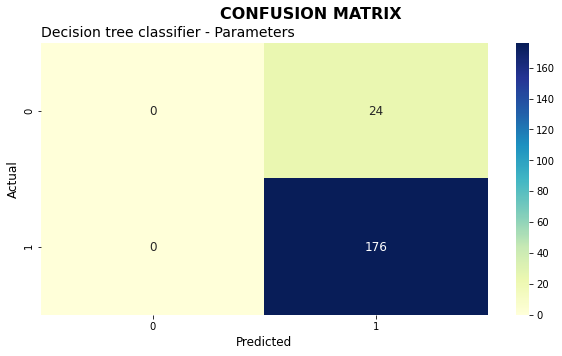

                                       Accuracy:   Precision:   Recall:   F1: 
Decision tree classifier - Parameters        0.88         0.88       1.0  0.94


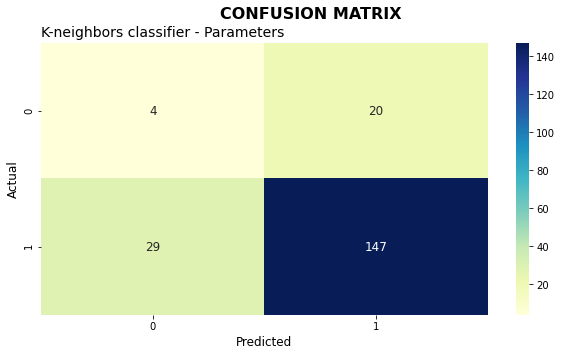

                                     Accuracy:   Precision:   Recall:   F1: 
K-neighbors classifier - Parameters        0.76         0.88      0.84  0.86


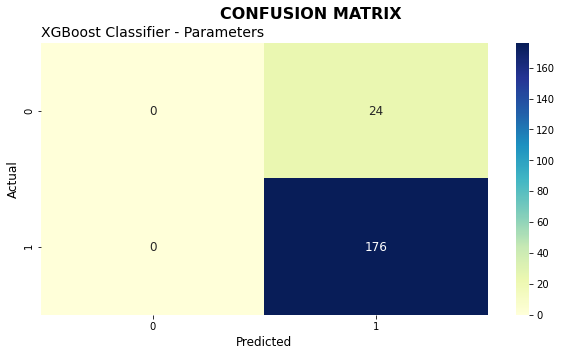

                                 Accuracy:   Precision:   Recall:   F1: 
XGBoost Classifier - Parameters        0.88         0.88       1.0  0.94


In [41]:
comparing_classification_models2 = pd.DataFrame()
comparing_classification_models2 = comparing_classification_models2.append(metrics_models(y_test, y_pred2, 'Decision tree classifier - Parameters'))
comparing_classification_models2 = comparing_classification_models2.append(metrics_models(y_test, y_pred_kn2, 'K-neighbors classifier - Parameters'))
comparing_classification_models2 = comparing_classification_models2.append(metrics_models(y_test, y_preds_xgb_2, 'XGBoost Classifier - Parameters'))


In [44]:
compare_models = comparing_classification_models.append([comparing_classification_models2])
compare_models

,Accuracy:,Precision:,Recall:,F1:
Decision tree classifier,0.84,0.92,0.90,0.91
K-neighbors classifier,0.87,0.89,0.98,0.93
XGBoost Classifier,0.87,0.91,0.95,0.93
Decision tree classifier - Parameters,0.88,0.88,1.00,0.94
K-neighbors classifier - Parameters,0.76,0.88,0.84,0.86
XGBoost Classifier - Parameters,0.88,0.88,1.00,0.94


Se puede observar que al modificar los parametros del analisis tiene en las metricas de los modelos. El decision tree classifier, aumenta su accuracy, recall y F1 al modificar parametros, pero disminuye su precision. El modelo KNN disminuye en todas las metricas al modificar los parametros, puede deverse a que el modelo predeterminado era mas adecuado para el conjunto de datos. Por ultimo, al modificar los parametros del modelo XGBoost aumenta el accuracy, recall y F1, pero disminye la precision.

### - Ejercicio 4
Compara su rendimiento utilizando la aproximación training/test o cross-validation.
<br>

como hemos utilizado los modelos con la aproximacion train/test, realizaremos la comparacion del rendimiento mediante cross-validation
>La validación cruzada es una técnica para evaluar cómo se generaliza el análisis estadístico a un conjunto de datos independiente. Es una técnica para evaluar modelos de aprendizaje automático entrenando varios modelos en subconjuntos de los datos de entrada disponibles y evaluándolos en el subconjunto complementario de los datos. Al usar la validación cruzada, hay muchas posibilidades de que podamos detectar el sobreajuste con facilidad.
<br>

Para validar el modelo utilizamos el k-Fold Cross-validation, el cual divide aleatoriamente el dataset en 'k' grupos. Uno de los grupos es utilizado como test set y los demas como training del modelo. 
 > *Cross-validation gives the model an opportunity to test on multiple splits so we can get a better idea on how the model will perform on unseen data.*

Se va a utilizar un valor de 5 para la cross-validation, lo que realiza una separacion en 5 grupos y realiza 'fit' del modelo y lo evalua 5 veces. Despues, se calcula el promedio de las 5 evaluaciones.
> *Generally, k-fold cross validation is the gold-standard for evaluating the performance of a machine learning algorithm on unseen data with k set to 3, 5, or 10*

*https://towardsdatascience.com/building-a-k-nearest-neighbors-k-nn-model-with-scikit-learn-51209555453a*
*https://scikit-learn.org/stable/modules/cross_validation.html*

### Decision tree classifier

In [77]:
#create a new KNN model
dt_cv = DecisionTreeClassifier()

#train model with cv of 5 
dt_scores = cross_val_score(dt_cv, X, y, cv=5)

#print cv score (accuracy) average 
print("Decission tree Accuracy: %.2f%% (%.2f%%)" % (dt_scores.mean()*100, dt_scores.std()*100))

Decission tree Accuracy: 84.70% (2.64%)


### Cross/validation of KNN model:

In [78]:
#create a new KNN model
knn_cv = KNeighborsClassifier(n_neighbors=3)

#train model with cv of 5 
knn_scores = cross_val_score(knn_cv, X, y, cv=5)

#print cv score (accuracy) average 
print("K nearest neighbors Accuracy: %.2f%% (%.2f%%)" % (knn_scores.mean()*100, knn_scores.std()*100))

K nearest neighbors Accuracy: 84.60% (1.32%)


### Cross-validation of XGBoost model:

In [79]:
#create new xgboost model
xgb_cv = xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)

#train model with cv of 5 
xgb_scores = cross_val_score(xgb_cv, X, y, cv=5)

#print cv score (accuracy) average 
print("XGBoost Accuracy: %.2f%% (%.2f%%)" % (xgb_scores.mean()*100, xgb_scores.std()*100))

XGBoost Accuracy: 89.80% (1.25%)


El promedio del 'accuracy' de la validacion una representacion mas adecuada de como se comportara el modelo con informacion que no ha visto antes. Se puede observar que el modelo XGBoost (89.8%) es el que tiene mejor accuracy promedio de la evaluacion, en comparacion con knn y decission tree.

## Nivel 2

### - Ejercicio 5
Realiza algún proceso de ingeniería de variables para mejorar su predicción
<br>

Los algoritmos de ML tienen un bajo rendimiento cuando tratan con dataset 'imbalanced', tendiendo a ignorar la clase minoritaria. Una manera de tratar este problema es 'oversample' la clase minoritaria generando datos sinteticos, utilizando por ejemplo SMOTE.
<br>

*https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/*

In [82]:
# count of true or false ArrDelay 
print(y_train.value_counts())

1    705
0     95
Name: ArrDelay, dtype: int64


Se puede observar que tenemos mas vuelos con retraso que sin retraso, por lo que es un imbalanced dataset

Counter({1: 881, 0: 119})
Counter({1: 881, 0: 881})


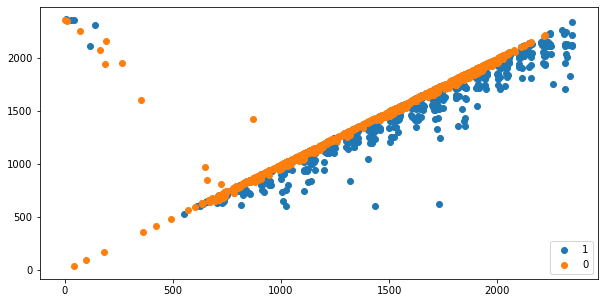

In [95]:
# Define variables predictoras
X = data_sampling.drop(['ArrDelay','Date','DayOfWeek'], axis = 1).values

# Define variable target
y = data_sampling['ArrDelay'].values

# summarize class distribution
counter = Counter(y)
print(counter)

# transform the dataset
oversample = SMOTE(sampling_strategy='minority')
X, y = oversample.fit_resample(X, y)

# summarize the new class distribution
counter = Counter(y)
print(counter)

# scatter plot of examples by class label
fig, ax = plt.subplots(figsize = (10,5))
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

Ahora despues de aplicar el SMOTE, se aplicaran los modelos de clasificacion para observar la diferencia en el rendimiento.

In [100]:
# instantiate Decision Tree classifer 
dt_class_smote = DecisionTreeClassifier()

# Train Decision Tree Classifer
dt_class_smote = dt_class_smote.fit(X_train,y_train)

#Predict the response for test dataset
y_pred_dt_smote = dt_class_smote.predict(X_test)

In [101]:
#instantiate Kn Classifier
kn_class_smote = KNeighborsClassifier(n_neighbors=5)

#Train Kn Classifier
kn_class_smote.fit(X_train, y_train)

#Predict with test data
y_pred_kn_smote = kn_class_smote.predict(X_test)

In [102]:
#instantiate XGBoost classifier
xg_class_smote = xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)

#fit the classification
xg_class_smote.fit(X_train,y_train)

#Predict on test
y_preds_xgb_smote = xg_class_smote.predict(X_test)

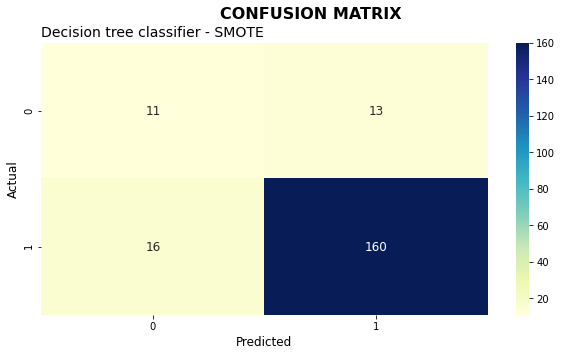

                                  Accuracy:   Precision:   Recall:   F1: 
Decision tree classifier - SMOTE        0.86         0.92      0.91  0.92


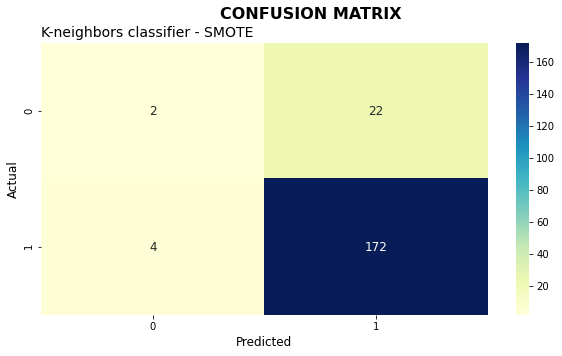

                                Accuracy:   Precision:   Recall:   F1: 
K-neighbors classifier - SMOTE        0.87         0.89      0.98  0.93


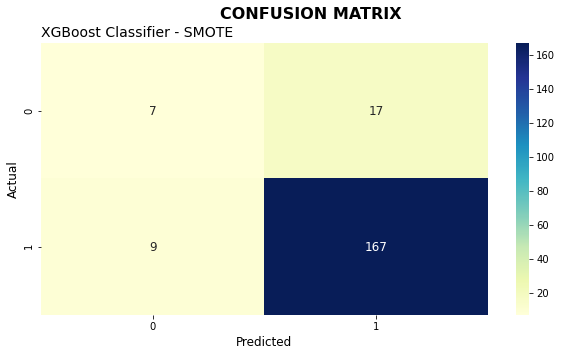

                            Accuracy:   Precision:   Recall:   F1: 
XGBoost Classifier - SMOTE        0.87         0.91      0.95  0.93


In [106]:
comparing_classification_models_smote = pd.DataFrame()
comparing_classification_models_smote = comparing_classification_models_smote.append(metrics_models(y_test, y_pred_dt_smote, 'Decision tree classifier - SMOTE'))
comparing_classification_models_smote = comparing_classification_models_smote.append(metrics_models(y_test, y_pred_kn_smote, 'K-neighbors classifier - SMOTE'))
comparing_classification_models_smote = comparing_classification_models_smote.append(metrics_models(y_test, y_preds_xgb_smote, 'XGBoost Classifier - SMOTE'))


In [107]:
compare_models2 = comparing_classification_models.append([comparing_classification_models2,comparing_classification_models_smote])
compare_models2

,Accuracy:,Precision:,Recall:,F1:
Decision tree classifier,0.84,0.92,0.90,0.91
K-neighbors classifier,0.87,0.89,0.98,0.93
XGBoost Classifier,0.87,0.91,0.95,0.93
Decision tree classifier - Parameters,0.88,0.88,1.00,0.94
K-neighbors classifier - Parameters,0.76,0.88,0.84,0.86
XGBoost Classifier - Parameters,0.88,0.88,1.00,0.94
Decision tree classifier - SMOTE,0.86,0.92,0.91,0.92
K-neighbors classifier - SMOTE,0.87,0.89,0.98,0.93
XGBoost Classifier - SMOTE,0.87,0.91,0.95,0.93


Se puede observar que modificar el dataset generando un oversample del minority class, la variacion en las metricas no muestra un aumento significativo.

## Nivel 3


### - Ejercicio 6
No utilices la variable DepDelay a la hora de hacer predicciones

In [115]:
# Define variables predictoras
X1 = data_sampling.drop(['ArrDelay','Date','DayOfWeek','DepDelay'], axis = 1).values

# Define variable target
y1 = data_sampling['ArrDelay'].values

#split test-train
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2)

In [116]:
# instantiate Decision Tree classifer 
dt_class_nodd = DecisionTreeClassifier()

# Train Decision Tree Classifer
dt_class_nodd = dt_class_nodd.fit(X1_train,y1_train)

#Predict the response for test dataset
y_pred_dt_nodd = dt_class_nodd.predict(X1_test)

In [117]:
#instantiate Kn Classifier
kn_class_nodd = KNeighborsClassifier(n_neighbors=5)

#Train Kn Classifier
kn_class_nodd = kn_class_nodd.fit(X1_train, y1_train)

#Predict with test data
y_pred_kn_nodd = kn_class_nodd.predict(X1_test)

In [118]:
#instantiate XGBoost classifier
xg_class_nodd = xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)

#fit the classification
xg_class_nodd = xg_class_nodd.fit(X1_train,y1_train)

#Predict on test
y_preds_xgb_nodd = xg_class_nodd.predict(X1_test)

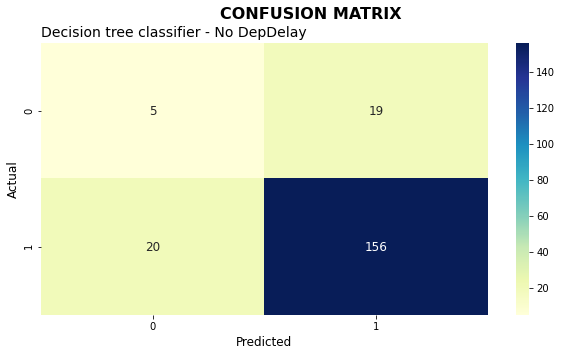

                                        Accuracy:   Precision:   Recall:   \
Decision tree classifier - No DepDelay         0.8         0.89      0.89   

                                        F1:   
Decision tree classifier - No DepDelay  0.89  


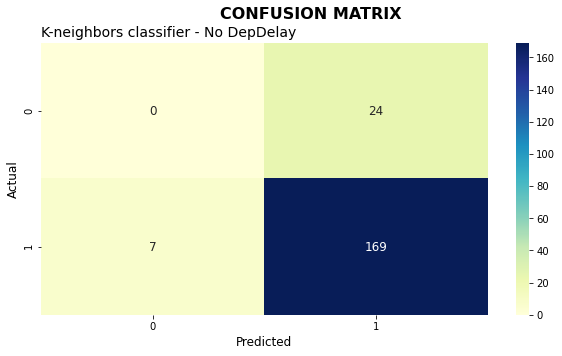

                                      Accuracy:   Precision:   Recall:   F1: 
K-neighbors classifier - No DepDelay        0.84         0.88      0.96  0.92


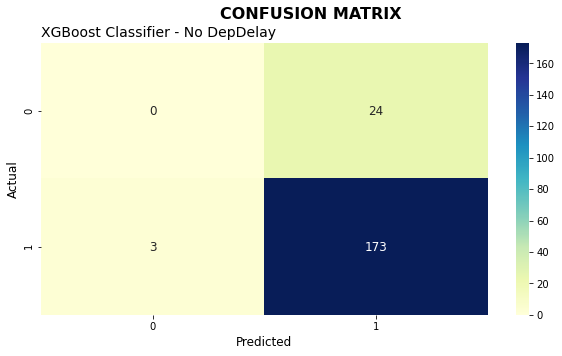

                                  Accuracy:   Precision:   Recall:   F1: 
XGBoost Classifier - No DepDelay        0.86         0.88      0.98  0.93


In [119]:
comparing_classification_models_nodd = pd.DataFrame()
comparing_classification_models_nodd = comparing_classification_models_nodd.append(metrics_models(y_test, y_pred_dt_nodd, 'Decision tree classifier - No DepDelay'))
comparing_classification_models_nodd = comparing_classification_models_nodd.append(metrics_models(y_test, y_pred_kn_nodd, 'K-neighbors classifier - No DepDelay'))
comparing_classification_models_nodd = comparing_classification_models_nodd.append(metrics_models(y_test, y_preds_xgb_nodd, 'XGBoost Classifier - No DepDelay'))

In [120]:
compare_models3 = comparing_classification_models.append([comparing_classification_models2,comparing_classification_models_smote,comparing_classification_models_nodd])
compare_models3

,Accuracy:,Precision:,Recall:,F1:
Decision tree classifier,0.84,0.92,0.90,0.91
K-neighbors classifier,0.87,0.89,0.98,0.93
XGBoost Classifier,0.87,0.91,0.95,0.93
Decision tree classifier - Parameters,0.88,0.88,1.00,0.94
K-neighbors classifier - Parameters,0.76,0.88,0.84,0.86
XGBoost Classifier - Parameters,0.88,0.88,1.00,0.94
Decision tree classifier - SMOTE,0.86,0.92,0.91,0.92
K-neighbors classifier - SMOTE,0.87,0.89,0.98,0.93
XGBoost Classifier - SMOTE,0.87,0.91,0.95,0.93
Decision tree classifier - No DepDelay,0.80,0.89,0.89,0.89


Ahora al comparar los metodos con los distintos parametros y tratamientos de datos, observamos que al remover la variable DepDelay el performance de los modelos de clasificacion es menor y, por lo tanto, bajan sus metricas. Esto se debe a que la variable DepDelay es la que brinda mas informacion para poder predecir el ArrDelay.